In [1]:
import warnings

warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.decomposition import PCA

# %%
import SpaCross as TOOLS

In [2]:
def load_data(config, proj_name):
    # %%
    data_root = Path('D:\\project\\datasets\\DLPFC\\')
    adata = sc.read_visium(data_root / proj_name, count_file=proj_name + "_filtered_feature_bc_matrix.h5")
    adata.var_names_make_unique()

    ##### Load layer_guess label, if have
    truth_path = "D:\\project\\datasets\\DLPFC\\" + proj_name + '/' + proj_name + '_truth.txt'
    Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    adata.obs['layer_guess'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

    edge_index = TOOLS.graph_construction(adata, config['data']['k_cutoff'])

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['data']['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X

    return adata, edge_index

In [3]:
def train_one(proj_name, adata, edge_index, config, clusType="mclust"):
    num_clusters = 5 if proj_name in ['151669', '151670', '151671', '151672'] else 7
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    net = TOOLS.SC_pipeline(adata, edge_index=edge_index, num_clusters=num_clusters, device=device, config=config, imputation=False)
    net.trian()
    enc_rep, recon = net.process()
    adata.obsm['latent'] = enc_rep
    adata.obsm['recon'] = recon
    adata.obs[clusType] = TOOLS.clustering(z=enc_rep, n_clust=num_clusters, num_seed=1, method=clusType)
    sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
    ARI, ACC, DIS = TOOLS.get_metrics(sub_adata, 'layer_guess', clusType)
    return ARI, ACC, DIS, adata

In [4]:
with open('../Config/DLPFC.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [5]:
tissue_name = "151675"
adata, edge_index = load_data(config, tissue_name)

In [6]:
ARI, ACC, DIS, adata = train_one(tissue_name, adata, edge_index, config)

Epoch 299 total loss=1.514 recon loss=0.961 mean loss=0.403 tri loss=1.361: 100%|██████████| 300/300 [00:10<00:00, 29.48it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


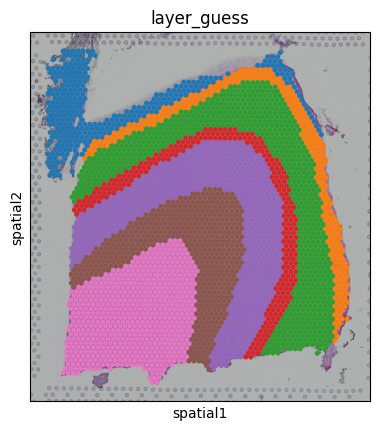

In [7]:
spot_size = 140
sc.pl.spatial(adata, color=['layer_guess'], spot_size=spot_size, legend_loc=None,
              title='layer_guess', show=True,
              )

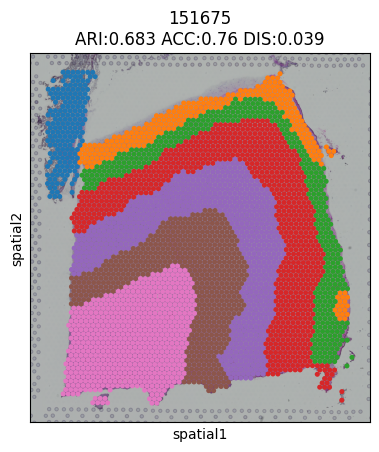

In [8]:
maps = {'7': 'Layer_1', '5': 'Layer_2', '6': 'Layer_3', '1': 'Layer_4', '2': 'Layer_5', '3': 'Layer_6', '4': 'WM'}
values = [maps[value] for value in adata.obs["mclust"]]
data = {'cluster': values}
df = pd.DataFrame(data, index=adata.obs["mclust"].index)
adata.obs['domain'] = df

sc.pl.spatial(adata, color=['domain'], spot_size=spot_size, legend_loc=None,
              title=tissue_name + '\nARI:' + str(round(ARI, 3)) + ' ACC:' + str(round(ACC, 3)) + ' DIS:' + str(round(DIS, 3)), show=True,
              )

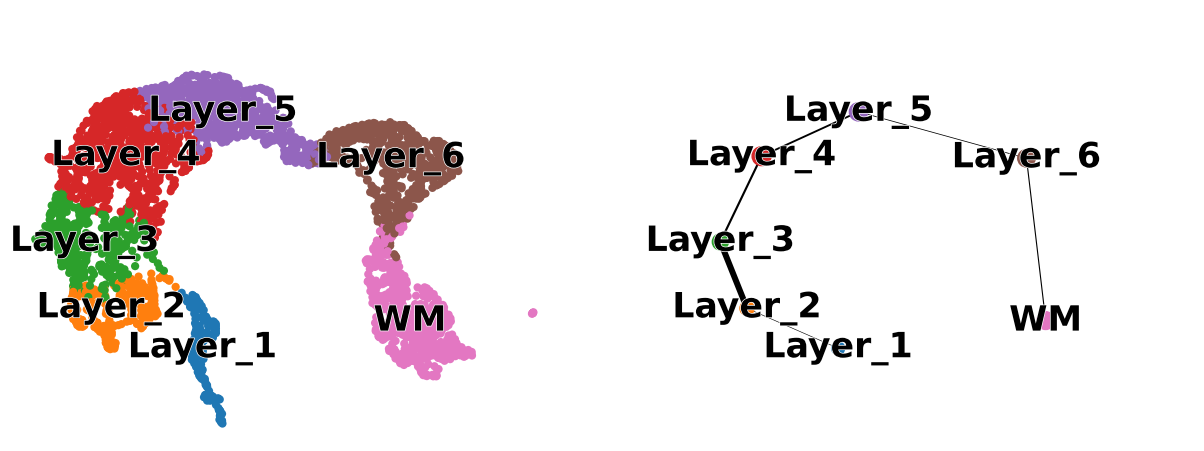

In [9]:

sc.pp.neighbors(adata, n_neighbors=12, n_pcs=16, use_rep="latent")
sc.tl.umap(adata)
sc.tl.paga(adata, groups='domain')
sc.pl.paga_compare(adata, legend_fontsize=25, frameon=False, size=spot_size, title=' ', legend_fontoutline=1, show=True)